In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd
import numpy as np
from skimage import exposure, color
import os
from skimage.io import imread

2023-06-07 21:41:09.395692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 21:41:09.436832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 21:41:09.437643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 21:41:10.062750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Let's explore the data folder
base_path = './data/'

# Let's define the classes
classes = os.listdir(base_path)

In [3]:
classes

['bottle', 'Empty', 'Glass']

In [4]:
#Function to do data augmentation
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (3, 90))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale


#balanced the data imbalance by data augmentation
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    for class_ in classes:
        if not class_.endswith('.DS_Store'):
            files = os.listdir(base_path+class_)
            #print(files)
            for file in files:
                if not file.endswith('.DS_Store'):
                    #print(file)
                    pic = load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                    numpy_image = np.array(pic)
                    Imagedatagen_input=np.expand_dims(numpy_image.astype("float32")/255,axis=0)
                    processed_image = preprocess_input(numpy_image)
                    X_list.append(processed_image)
                    y_list.append(class_)
                    
                        contrasting_image=ImageDataGenerator(zca_whitening=False,rotation_range=30,
                                                    width_shift_range=0,
                                                    height_shift_range=0.5,
                                                    shear_range=0,
                                                    zoom_range=0,
                                                    fill_mode='nearest',
                                                    horizontal_flip=False,
                                                    vertical_flip=False,
                                                    preprocessing_function=contrast_stretching,
                                                    data_format=K.image_data_format())
                        
                        i=0
                        for img_batch in contrasting_image.flow(Imagedatagen_input,batch_size=6, shuffle=False):
                            
                            for img in img_batch:
                                X_list.append(img)
                                y_list.append(class_)
                                i+=1
                            if i >= 6:
                                break
                    if class_=='bottle':
                        contrasting_image=ImageDataGenerator(zca_whitening=False,rotation_range=30,
                                                    width_shift_range=0,
                                                    height_shift_range=0.5,
                                                    shear_range=0,
                                                    zoom_range=0,
                                                    fill_mode='nearest',
                                                    horizontal_flip=False,
                                                    vertical_flip=False,
                                                    preprocessing_function=contrast_stretching,
                                                    data_format=K.image_data_format())
                        
                        i=0
                        for img_batch in contrasting_image.flow(Imagedatagen_input,batch_size=2, shuffle=False):
                            
                            for img in img_batch:
                                X_list.append(img)
                                y_list.append(class_)
                                i+=1
                            if i >= 2:
                                break  
                    if class_=='Glass':
                        contrasting_image=ImageDataGenerator(zca_whitening=False,rotation_range=30,
                                                    width_shift_range=0,
                                                    height_shift_range=0.5,
                                                    shear_range=0,
                                                    zoom_range=0,
                                                    fill_mode='nearest',
                                                    horizontal_flip=False,
                                                    vertical_flip=False,
                                                    preprocessing_function=contrast_stretching,
                                                    data_format=K.image_data_format())
                        
                        i=0
                        for img_batch in contrasting_image.flow(Imagedatagen_input,batch_size=3, shuffle=False):
                           
                            for img in img_batch:
                                X_list.append(img)
                                y_list.append(class_)
                                i+=1
                            if i >= 3:
                                break                  
                    
    
    return X_list, y_list, classes

In [ ]:
X_list, y_list, classes=load_image(base_path)

In [6]:
X = np.array(X_list)
y = np.array(y_list)


In [7]:
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [8]:
X.shape,len(y),len(classes)

((5403, 224, 224, 3), 5403, 3)

In [9]:
from tensorflow.keras.utils import to_categorical
y_series = pd.Series(y).map({classes[0]:0, classes[1]:1,classes[2]:2})
y = to_categorical(y_series)

In [10]:
y.shape

(5403, 3)

In [11]:
# base_model = keras.applications.vgg16.VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)
#vgg16 model did not help much

In [12]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'
)



In [14]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization

In [15]:
# Clear session and build above model:
K.clear_session()
new_model = keras.models.Sequential([
    Conv2D(filters = 8, kernel_size = (6,6),padding = 'valid',activation = 'relu' ,input_shape = (224,224,3)),
    Conv2D(filters = 3, kernel_size = (5,5), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (5,5),padding = 'valid'),

  
    Flatten(),
    #Fully connected layers:
        
    Dropout(0.005),
    # fc1 fully connected layer
    Dense(units=60, activation='relu', name='fc1'),
    
    # fc2 fully connected layer
    #Dense(units=40, activation='relu', name='fc2'),
    #Dense(units=30, activation='relu', name='fc3'),
    # _Dropout(0.2), - optional
    
    Dense(units=3, activation=keras.activations.softmax, name='output')   
])

In [16]:
new_model.summary()
new_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

history = new_model.fit(X,y,batch_size=500, epochs=100, validation_split=.2,callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 8)       872       
                                                                 
 conv2d_1 (Conv2D)           (None, 215, 215, 3)       603       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5547)              0         
                                                                 
 dropout (Dropout)           (None, 5547)              0         
                                                                 
 fc1 (Dense)                 (None, 60)                332880    
                                                        

2023-06-07 21:42:02.110965: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2602328064 exceeds 10% of free system memory.
2023-06-07 21:42:04.313957: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 767376000 exceeds 10% of free system memory.
2023-06-07 21:42:07.785760: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 767376000 exceeds 10% of free system memory.


1/9 [==>...........................] - ETA: 2:34 - loss: 11.1113 - accuracy: 0.2120

2023-06-07 21:42:22.722880: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 767376000 exceeds 10% of free system memory.
2023-06-07 21:42:25.730113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 767376000 exceeds 10% of free system memory.


9/9 [==============================] - 166s 18s/step - loss: 6.3391 - accuracy: 0.3510 - val_loss: 1.0282 - val_accuracy: 0.6022
Epoch 2/100
9/9 [==============================] - 170s 19s/step - loss: 0.9364 - accuracy: 0.6481 - val_loss: 0.8557 - val_accuracy: 0.6827
Epoch 3/100
9/9 [==============================] - 172s 19s/step - loss: 0.8035 - accuracy: 0.6326 - val_loss: 0.7834 - val_accuracy: 0.5800
Epoch 4/100
9/9 [==============================] - 175s 19s/step - loss: 0.7484 - accuracy: 0.6416 - val_loss: 0.7249 - val_accuracy: 0.7401
Epoch 5/100
9/9 [==============================] - 177s 20s/step - loss: 0.6576 - accuracy: 0.7658 - val_loss: 0.6092 - val_accuracy: 0.7438
Epoch 6/100
9/9 [==============================] - 179s 20s/step - loss: 0.5440 - accuracy: 0.8163 - val_loss: 0.4842 - val_accuracy: 0.8270
Epoch 7/100
9/9 [==============================] - 179s 20s/step - loss: 0.4125 - accuracy: 0.8744 - val_loss: 0.3832 - val_accuracy: 0.8964
Epoch 8/100
9/9 [========

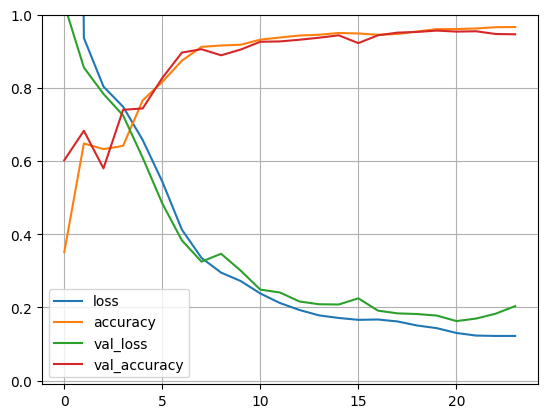

In [17]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.01,1)
plt.show()
# plt.savefig('conv_frozen_new_fcl.png')

In [18]:
new_model.save('denselayer.h5')